# Random Forest

D'abord nous importons toutes les librairies nécessaire à l'implémentation de la méthode sous python.

In [1]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Nous créons aussi deux fonctions utile pour l'évaluation de nos modèles et nous téléchargeons les données sur lesquels nous devons travailler.

In [2]:
def F1(model,X,Y) :
    Y_model =model.predict(X)
    f1_scor = f1_score(Y,Y_model)
    return(f1_scor)

In [3]:
def result_model(model,X,Y) :
    Y_model =model.predict(X)

    f1_scor = f1_score(Y,Y_model)
    print('Le f1 score vaut',f1_scor)
    
#     score = cross_val_score(model,X,Y,cv=5,scoring = make_scorer(f1_score))
#     print('F1 cross validé :', np.mean(score))
    
   # Matrice de confusion
    cm_model = confusion_matrix(Y, Y_model)
    plt.rcParams['figure.figsize'] = (5, 5)
    sns.heatmap(cm_model, annot = True)
    plt.title(str(model))
    plt.show()
    
    # return()

In [4]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

In [5]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,30,1,28,0,1,1,26891,3,270,1
1,0,28,1,28,1,0,0,45434,0,146,0
2,0,32,1,47,0,1,0,2630,3,195,1
3,0,54,1,28,0,1,0,41420,1,121,0
4,0,45,1,36,0,1,1,32764,2,185,1


# Pre-processing

On sépare la variable à expliquer des variables explicatives.

In [6]:
# Variables explicative
exp_var = train.columns[:-1]

# Décomposition features / target
X = train[exp_var]
Y = train['Response']

In [7]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,0,30,1,28,0,1,1,26891,3,270
1,0,28,1,28,1,0,0,45434,0,146
2,0,32,1,47,0,1,0,2630,3,195
3,0,54,1,28,0,1,0,41420,1,121
4,0,45,1,36,0,1,1,32764,2,185


On sépare les données en train et test puis on les scale avec les méthodes de sklearn.

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.85)

scaler=StandardScaler() 

X_scal_train = scaler.fit_transform(X_train)
X_scal_test = scaler.transform(X_test) 

X_scal_train = pd.DataFrame(X_scal_train,index= X_train.index, columns=exp_var)
X_scal_test = pd.DataFrame(X_scal_test,index= X_test.index, columns=exp_var)

On fait un premier test avec les hyper-paramêtres par défaut 

Le f1 score vaut 0.379754242246928


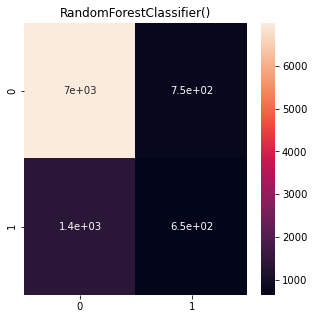

In [9]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)

In [10]:
cross_val_score(rfc, X_train, Y_train, cv=5, scoring='f1')

array([0.39772139, 0.38788193, 0.40021036, 0.40639505, 0.39623601])

On fait aussi l'entrainement avec les variables normalisées pour voir si les résultats différents, mais ça ne semble pas être le cas.

Le f1 score vaut 0.40069384215091064


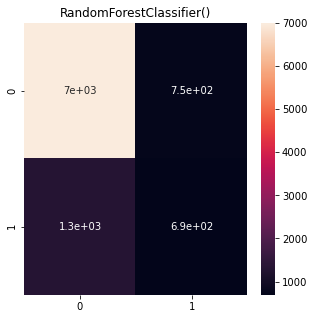

In [11]:
rfc = RandomForestClassifier()
rfc.fit(X_scal_train, Y_train)
Y_rfc = result_model(rfc, X_scal_test, Y_test)

In [12]:
cross_val_score(rfc, X_scal_train, Y_train, cv=5, scoring='f1')

array([0.39623135, 0.3870801 , 0.39978986, 0.4083442 , 0.39113827])

Afin d'avoir une meilleur compréhension de nos modèle on peut aussi observer quels sont les variables qui leurs apportent le plus d'informations et sont les plus importantes.

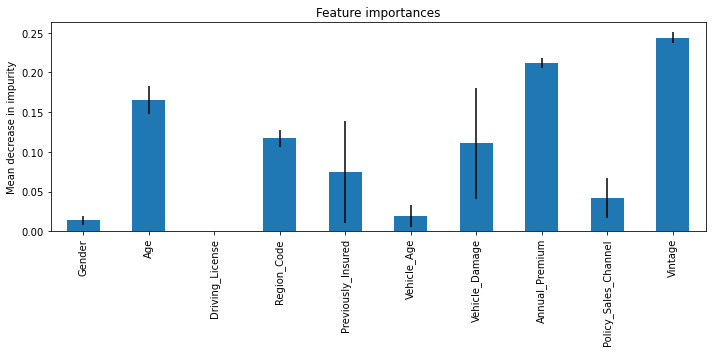

In [13]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

feature_names = [i for i in X.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Tuning

## Il y'a de nombreux paramêtres à tuner :
### Nous allons intervenir sur les paramêtres suivant et procéder dans l'ordre dans lesquels les paramêtres sont présentés

n_estimatorsint, default=100, ce paramêtre correspond au nombre d'arbre, il est sans doute le plus important donc nous interviendrons deux fois dessus

max_depthint, correspond à la profondeur maximal des arbres default=None

min_samples_splitint, correspond au nombre de divergences nécessaire pour créer un nouveau noeud default=2

min_samples_leafint, correspond au nombre minimum d'observations dans une feuille simple default=1

min_impurity_decreasefloat, correspond à l'apport minimum d'une fuille pour qu'elle soit conservé default=0.0

n_estimatorsint, le nombre d'arbre à nouveau, au cas où les paramêtres modifiés modifié à leur tour le nombre d'arbre optimal, default=100

max_features{“auto”, “sqrt”, “log2”}, default= "auto", les 3 modes de calculs de features max qu'il faut tester

class_weight{“balanced”, “balanced_subsample”}, default=None, les 2 options pour mettre des poids sur les observations

#### On reprend tout d'abord le résultat de base avant de commencer notre tuning

Le f1 score vaut 0.3884176659842059


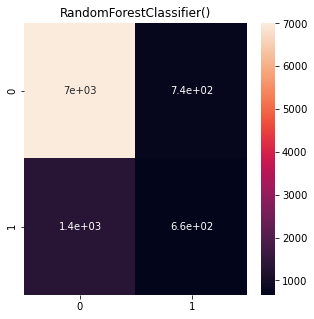

In [14]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)

# n_estimators

La méthode que nous allons utiliser pour le tuning est très simple nous allons tester des valeurs parmi une liste, gardans la meilleur valeur avant de répéter le processus à avec les valeurs proches de l'optimum et en s'aidant de l'allure du graphe de nos F1 scores en fonction de nos paramêtre pour savoir dans quelle directions s'orienter.

In [15]:
maxi=F1(rfc, X_scal_test, Y_test)
kmaxi=100

100 0.4046043165467626


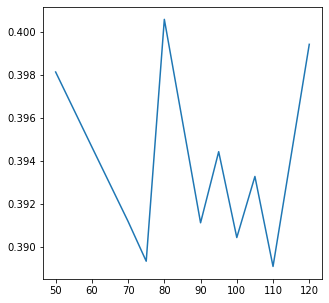

In [38]:
T=[]
#test=[50,75,100,115,120,130,200]
test=[50,60,70,75,80,90,95,100,105,110,120]
for k in test:
    rfc = RandomForestClassifier(max_depth=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [40]:
n_estimators_int=kmaxi
print("on choissit donc",kmaxi,"comme la valeur pour","n_estimators_int")

on choissit donc 100 comme la valeur pour n_estimators_int


Nous n'observons pas de tendances sur le graphe donc nous pouvons nous arréter là, mais nous aurions aussi pû essayer de regarder aux alentours de 100 s'il y'avait de meilleurs prétendants.

# Max depth
Nous répétons le processus pour ce paramêtre, le bridant simplement à 100 maximum

In [41]:
maxi=F1(rfc, X_test, Y_test)
kmaxi=100

130 0.40566310314937876


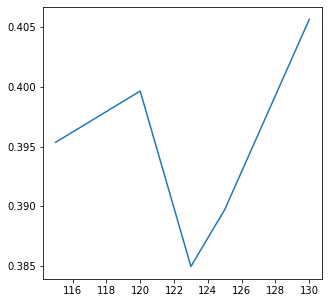

In [42]:
T=[]
#test=[1,5,10,20,100]
#test=[20,100,200]
#test=[70,90,95,100,105,110]
test=[115,120,123,125,130]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

Le f1 score vaut 0.3929601846508944


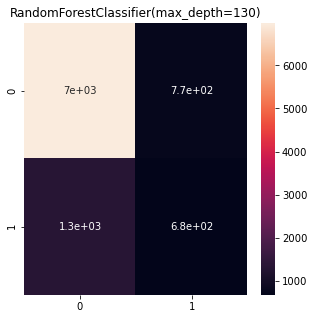

In [43]:
max_depth_int=kmaxi
rfc = RandomForestClassifier(max_depth=max_depth_int)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)
rfc.fit(X_train, Y_train)
maxi= F1(rfc, X_test, Y_test)
kmaxi=2

# min_samples_split
Nous répétons le processus pour ce paramêtre.

3 0.40553792904528413


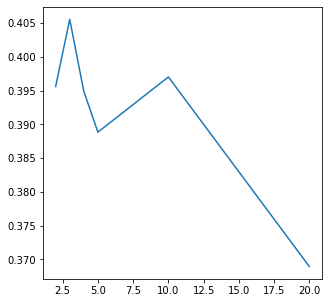

In [44]:
T=[]
test=[2,3,4,5,10,20]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [45]:
min_samples_split_int=kmaxi
print("on choissit donc",kmaxi,"comme la valeur pour","min_samples_split_int")

on choissit donc 3 comme la valeur pour min_samples_split_int


Le f1 score vaut 0.39999999999999997


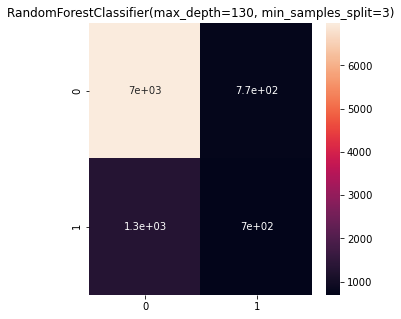

In [46]:
rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)
maxi=F1(rfc, X_test, Y_test)
kmaxi=1

# min_samples_leaf
Nous répétons le processus pour ce paramêtre.

1 0.4024496937882765


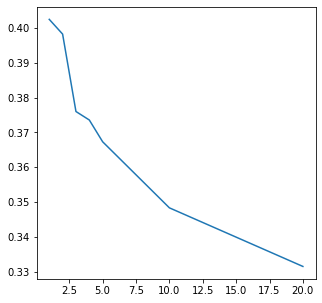

In [47]:
T=[]
test=[1,2,3,4,5,10,20]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [48]:
min_samples_leaf_int=kmaxi
print("on choissit donc",kmaxi,"comme la valeur pour","min_samples_leaf_int")

on choissit donc 1 comme la valeur pour min_samples_leaf_int


# min_impurity_decrease
Nous répétons le processus pour ce paramêtre

Le f1 score vaut 0.406041243101946


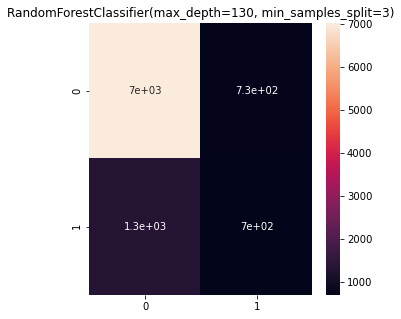

In [49]:
rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)
maxi=F1(rfc, X_test, Y_test)
kmaxi=0

0 0.406041243101946


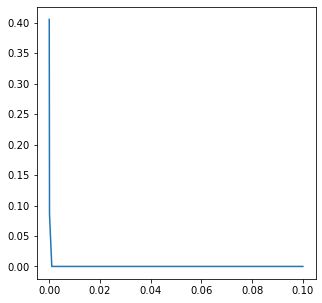

In [50]:
T=[]
test=[0,0.0001,0.001,0.05,0.1]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [51]:
min_impurity_decrease_int=kmaxi
print("on choissit donc",kmaxi,"comme la valeur pour","min_impurity_decrease_int")

on choissit donc 0 comme la valeur pour min_impurity_decrease_int


Le f1 score vaut 0.39976891969959566


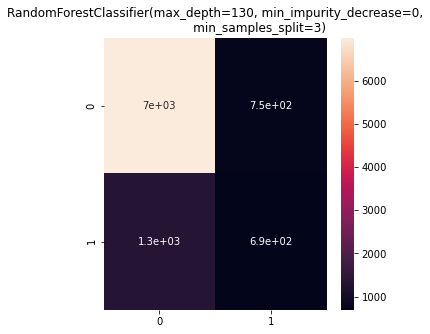

In [52]:
rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)
maxi=F1(rfc, X_test, Y_test)
kmaxi=0

# n_estimators

100 0.41077055285018615


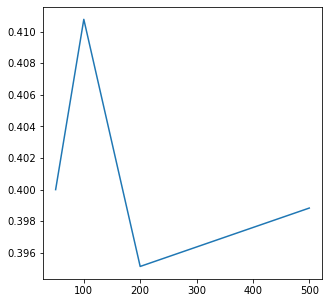

In [53]:
T=[]
test=[50,100,200,500]
for k in test:
    rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [54]:
n_estimators_int=kmaxi
print("on choissit donc",kmaxi,"comme la valeur pour","n_estimators_int")

on choissit donc 100 comme la valeur pour n_estimators_int


# max_features{“auto”, “sqrt”, “log2”}, default= "auto"

In [55]:
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int)
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec auto F1=",newF)
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="sqrt")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec sqrt F1=",newF)
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2")
rfc.fit(X_train, Y_train)
newF= F1(rfc, Xl_test, Y_test)
print("avec log2 F1=",newF)

avec auto F1= 0.4009256580850449
avec sqrt F1= 0.3924746743849494
avec log2 F1= 0.40011547344110854


On observe de meilleur résultat avec la valeur par défaut qui correspond au mode automatique donc nous le conservons dans notre tuning.

#### log2 semble meilleur 

Le f1 score vaut 0.3982758620689655


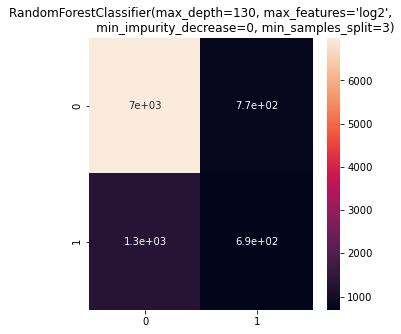

In [56]:
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2")
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)
maxi=F1(rfc, X_test, Y_test)

# class_weight{“balanced”, “balanced_subsample”}, default=None

In [57]:
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec auto F1=",newF)
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2",
                            class_weight="balanced")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec balanced F1=",newF)
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2",
                            class_weight="balanced_subsample")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec balanced_subsample F1=",newF)

avec auto F1= 0.40242844752818735
avec balanced F1= 0.42964196502914237
avec balanced_subsample F1= 0.41696700859439983


nos résultats sont meilleurs avec l'option de balanced weight donc nous la conservons pour notre modèle.

# Méthode tatonement aléatoire
Afin d'améliorer notre tuning nous pouvons aussi utilisés des méthodes aléatoires, leurs intérêts résside dans le fait qu'elle permettents des modifications plus subtil ou au contraire plus imprévisible et désorganisé que celle pensé par un humain, et donc inexploré.
Cette version est relativement naive et ne  possède que peu d'itération mais il est possible d'en faire une méthode beaucoup plus poussé, ce code est présent uniquement à titre d'exemple.

In [58]:
def variation(param):
    modif=np.random.randint(0,5)
    if modif==3:
        param[3]=param[3]*np.random.uniform(0.5,1.5)+np.random.uniform()/100
    if modif==0 or modif==4:
        param[modif]=int(param[modif]*np.random.uniform(0.5,1.5))+1
    else:
        param[modif]=param[modif]*np.random.uniform(0.5,1.5)
    rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
    rfc.fit(X_scal_train, Y_train)
    newF= F1(rfc, X_scal_test, Y_test)
    return(param,newF)

In [59]:
def variation2(param):
    modif=np.random.randint(0,5)
    if modif==3:
        param[3]=param[3]*np.random.uniform(0,10)+np.random.uniform()/100
    if modif==0 or modif==4:
        param[modif]=int(param[modif]*np.random.uniform(0.5,5))+1
    else:
        param[modif]=param[modif]*np.random.uniform(0.5,1.5)
    rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
    rfc.fit(X_scal_train, Y_train)
    newF= F1(rfc, X_scal_test, Y_test)
    return(param,newF)

In [60]:
param=[max_depth_int,0.5,0.25,min_impurity_decrease_int,n_estimators_int]
print(param)

[130, 0.5, 0.25, 0, 100]


0
1
evolution !!!!!
evolution !!!!!
2
3
4
evolution !!!!!
5
6
7
8
9
[462, 0.6809890717276842, 0.13160002688359748, 0.20373012035970045, 529]


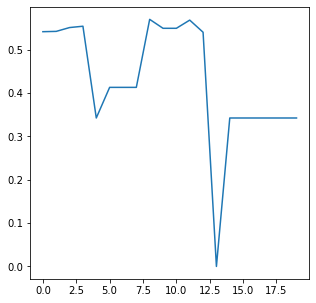

In [61]:
T=[]
rip=0
param=[max_depth_int,0.5,0.25,min_impurity_decrease_int,n_estimators_int]
rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
for k in range(10): #ou 100 voir 2000 pendant la nuit
    rip=rip+1
    print(k)
    nparam,nF=variation(param)
    T.append(nF)
    if nF>newF:
        newF=nF
        param=nparam
        print("evolution !!!!!")
        rip=0
    nparam,nF=variation2(param)
    T.append(nF)
    if nF>newF:
        newF=nF
        param=nparam
        print("evolution !!!!!")
        rip=0
    if rip==100:
        break
print(param)
plt.plot(T)
plt.show()
plt.show()

[462, 0.6809890717276842, 0.13160002688359748, 0.20373012035970045, 529]


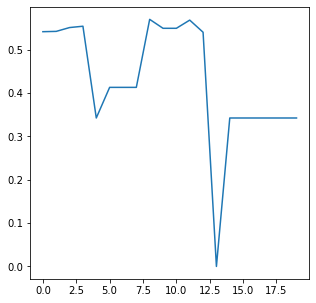

In [62]:
print(param)
plt.plot(T)
plt.show()

In [63]:
rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)

Au final le F1 score que nous obtenons est relativement correct sur cette base de test avec un résultat de 0.35 environ

In [64]:
newF

0.342216941096588

Afin d'avoir une meilleur vision sur notre modèle dans un cas plus généralnous pouvons effectuer une cross validation qui prends plus de variété dans ses tests et évalutation.

In [65]:
scores = cross_val_score(rfc, X, Y, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores.mean(), scores.std()))

F1 moyen de 0.20 avec un écart type de 0.17


In [66]:
rfc = RandomForestClassifier(min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4], class_weight="balanced")
rfc.fit(X_scal_train, Y_train)
newF= F1(rfc, X_scal_test, Y_test)

In [67]:
scores = cross_val_score(rfc, X, Y, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores.mean(), scores.std()))

F1 moyen de 0.20 avec un écart type de 0.17
